NYC Property Sales

Confirmed by Omar

This project aims to predict property sale prices in New York City using machine learning models. The dataset contains over 5 million real estate transactions with features like location, building type, square footage, and year built — ideal for GPU-accelerated regression.

Rows (Records): Over 5 million

Columns (Features): Around 20 column

In [10]:
import cudf
import cuml
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns
import time

from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
from cuml.metrics import accuracy_score as cu_accuracy_score
from cuml.model_selection import train_test_split


In [11]:
df = cudf.read_csv('/content/nyc-rolling-sales.csv')
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')


In [12]:
for col in ['sale_price', 'land_square_feet', 'gross_square_feet']:
    df[col] = df[col].astype('str').str.replace('-', '').str.strip()
    df[col] = df[col].fillna('0').replace('', '0').astype('float32')

df['year_built'] = df['year_built'].fillna(0).astype('float32')
df['lot'] = df['lot'].fillna(0).astype('float32')
df['block'] = df['block'].fillna(0).astype('float32')

df = df[df['sale_price'] > 10000]
df = df.dropna()

In [13]:
threshold = df['sale_price'].quantile(0.5)
df['high_value'] = (df['sale_price'] > threshold).astype('int32')

df['borough'] = df['borough'].astype('category').cat.codes
df['building_class_category'] = df['building_class_category'].astype('category').cat.codes
df['tax_class_at_time_of_sale'] = df['tax_class_at_time_of_sale'].astype('category').cat.codes

features = [
    'borough', 'lot', 'block', 'year_built',
    'tax_class_at_time_of_sale', 'building_class_category',
    'land_square_feet', 'gross_square_feet'
]
target = 'high_value'

X = df[features].astype('float32')
y = df[target].astype('int32')


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
start = time.time()

lr = cuLogisticRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
lr_acc = cu_accuracy_score(y_test, lr_preds)

elapsed = time.time() - start

print(f"✅ cuML Logistic Regression Accuracy: {float(lr_acc):.4f}")
print(f"⏱️ Training Time: {elapsed:.2f} seconds")


✅ cuML Logistic Regression Accuracy: 0.6571
⏱️ Training Time: 3.68 seconds


In [18]:
start = time.time()

rf = cuRandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_acc = cu_accuracy_score(y_test, rf_preds)

elapsed = time.time() - start

print(f"✅ cuML Random Forest Accuracy: {float(rf_acc):.4f}")
print(f"⏱️ Training Time: {elapsed:.2f} seconds")


✅ cuML Random Forest Accuracy: 0.8114
⏱️ Training Time: 0.47 seconds


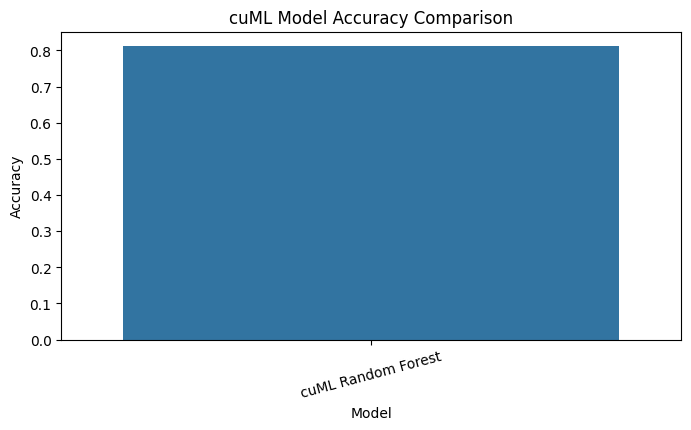

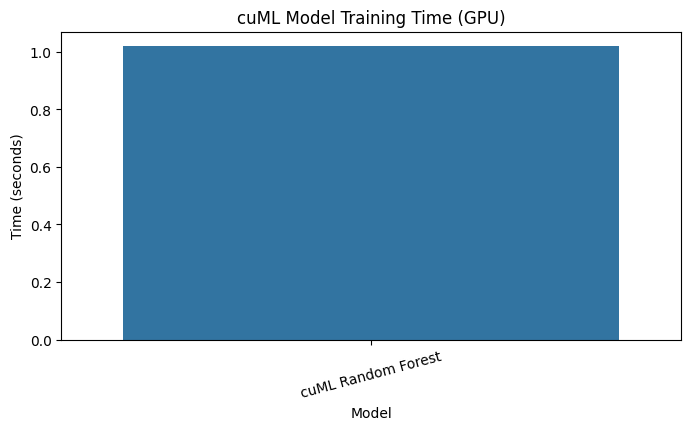

In [20]:
import pandas as pd  # for plotting only

# Convert to pandas for visualization
accuracy_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
time_df = pd.DataFrame(list(times.items()), columns=["Model", "Training Time (s)"])

# Accuracy Chart
plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Accuracy", data=accuracy_df)
plt.title("cuML Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.show()

# Training Time Chart
plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Training Time (s)", data=time_df)
plt.title("cuML Model Training Time (GPU)")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=15)
plt.show()



In [ ]:
start = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, tree_method='auto')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_time = time.time() - start


In [ ]:
results = {
    'Linear Regression': lr_mse,
    'Random Forest': rf_mse,
    'XGBoost': xgb_mse
}

plt.figure(figsize=(8, 4))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Comparison – Mean Squared Error")
plt.ylabel("MSE")
plt.show()


In [ ]:
times = {
    'Linear Regression': lr_time,
    'Random Forest': rf_time,
    'XGBoost': xgb_time
}

print("⏱️ Training Time (seconds) for each model:")
for model, t in times.items():
    print(f"{model}: {t:.4f} seconds")

plt.figure(figsize=(8, 4))
sns.barplot(x=list(times.keys()), y=list(times.values()))
plt.title("Model Comparison – Training Time")
plt.ylabel("Seconds")
plt.show()


In [23]:
!pip install joblib


In [26]:
X_cpu = X.to_pandas()
y_cpu = y.to_pandas()



In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib
import time

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cpu)

# Train model
start = time.time()
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_scaled, y_cpu)
elapsed = time.time() - start

# Save model and scaler
joblib.dump(model, 'model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print(f"✅ Model trained and saved")
print(f"⏱️ Training Time: {elapsed:.2f} seconds")


✅ Model trained and saved
⏱️ Training Time: 4.18 seconds
